In [ ]:
from astropy.io import fits
import numpy as np
from astropy.coordinates import SkyCoord
import astropy.units as u
import astropy.stats
import astropy.table
from astropy.table import join
import astropy.wcs
import astropy.cosmology
import matplotlib.pyplot as plt
import pandas as pd
from astropy.io import ascii
import scipy.integrate as integrate
import scipy.optimize as optimize
from astropy.cosmology import FlatLambdaCDM

In [ ]:
li=ascii.read(r"/content/Li data.txt")
li

col1,col2,col3,col4,col5,col6,col7,col8,col9,col10,col11,col12,col13,col14,col15,col16,col17,col18,col19
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str5,str4,float64,float64,float64,float64,float64
34,3.591921,-30.41574,2.07,7.72,-0.14,0.19,0.33,-0.04,0.05,2.82,0.15,0.87,0.03,0.85,0.02,8.03,0.02,3.04
245,3.599965,-30.40957,1.81,7.78,-0.17,0.19,0.39,-0.08,0.06,0.47,0.05,1.60,0.89,1.02,0.11,7.6,0.52,6.29
282,3.577672,-30.408856,2.26,7.05,-0.09,0.09,0.01,-0.01,0.01,0.45,0.06,0.69,0.05,0.48,0.03,8.13,0.03,2.31
614,3.618857,-30.403802,2.2,7.11,-0.08,0.08,0.19,-0.04,0.04,1.24,0.25,0.86,0.13,1.15,0.28,8.03,0.08,1.0
882,3.602338,-30.400736,1.81,8.58,-0.15,0.16,0.2,-0.04,0.08,0.64,0.08,0.04,0.08,0.63,0.08,8.52,0.05,2.23
1018,3.606238,-30.397984,2.28,6.89,-0.17,0.24,0.12,-0.03,0.05,1.05,0.1,1.68,0.61,0.8,0.07,7.55,0.36,1.78
1085,3.604176,-30.39717,2.07,9.37,-0.2,0.15,0.38,-0.04,0.05,3.93,0.26,0.16,0.03,0.75,0.09,8.44,0.02,1.85
1333,3.606056,-30.393533,2.18,8.42,-0.25,0.18,0.3,-0.07,0.09,1.48,0.16,0.80,0.06,1.13,0.11,8.07,0.03,1.68
1407,3.611638,-30.392479,2.28,7.45,-0.3,0.3,0.13,-0.03,0.04,0.86,0.08,1.03,0.10,1.05,0.09,7.93,0.06,1.53


In [ ]:
Li_data = astropy.table.Table({'ID': li['col1'],
                                  'R.A': li['col2'],
                                  'D.E': li['col3'],
                                  'Z': li['col4'],
                                  'logMstar':li['col5'],
                                  'e_Mstar':((-1*li['col6']+li['col7'])/2),
                                  'logSFR':li['col11'],
                                  'e_logSFR':li['col12']})


Li_data



ID,R.A,D.E,Z,logMstar,e_Mstar,logSFR,e_logSFR
int64,float64,float64,float64,float64,float64,float64,float64
34,3.591921,-30.41574,2.07,7.72,0.165,2.82,0.15
245,3.599965,-30.40957,1.81,7.78,0.18,0.47,0.05
282,3.577672,-30.408856,2.26,7.05,0.09,0.45,0.06
614,3.618857,-30.403802,2.2,7.11,0.08,1.24,0.25
882,3.602338,-30.400736,1.81,8.58,0.155,0.64,0.08
1018,3.606238,-30.397984,2.28,6.89,0.20500000000000002,1.05,0.1
1085,3.604176,-30.39717,2.07,9.37,0.175,3.93,0.26
1333,3.606056,-30.393533,2.18,8.42,0.215,1.48,0.16
1407,3.611638,-30.392479,2.28,7.45,0.3,0.86,0.08


In [ ]:
#function for fitting the values to a straight line of for y=mx+c
def linear_fit(x,y,co):
    A_transpose=np.matrix(np.ones(len(x)))
    A_transpose=np.vstack([A_transpose,x])
    A=A_transpose.transpose()
    Y=np.matrix(y)
    covar=np.diag(co*co)
    Y_transpose=Y.transpose()
    Cinv=np.linalg.inv(covar)
    B=np.matmul(A_transpose,Cinv)
    D=np.matmul(B,A)
    E=np.linalg.inv(D)
    F=np.matmul(B,Y_transpose)
    const=np.matmul(E,F)

    return(const,E)


<ipython-input-5-cef2c0c11df0>:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  b=float(low_p[0])
<ipython-input-5-cef2c0c11df0>:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  gamma=float(low_p[1])


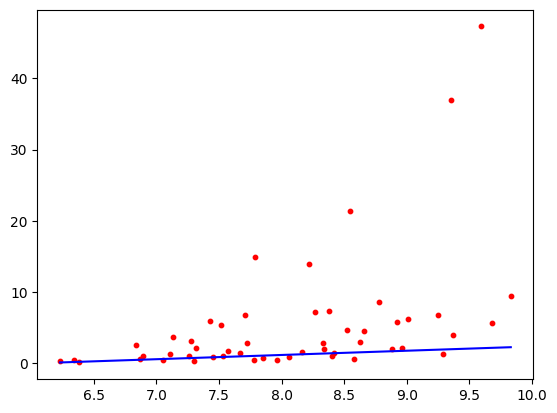

gamma =  0.596022834334522 ± 0.01907481676440342
b =  -3.611926555294322 ± 0.13855087934058274


In [ ]:
low_p,err_low_p=linear_fit(Li_data['logMstar'],Li_data['logSFR'],Li_data['e_logSFR'])

plt.scatter(Li_data['logMstar'],Li_data['logSFR'],color='red',s=10)
#plt.errorbar(x,y,co_low,fmt='o',color='r')

b=float(low_p[0])
gamma=float(low_p[1])




k = np.linspace(min(Li_data['logMstar']),max(Li_data['logMstar']),100)

l =(k*gamma)+b


plt.plot(k, l, color='blue')


plt.show()
residual=Li_data['logSFR']-((gamma*Li_data['logMstar'])+b)
delta_sqrd=np.mean((residual**2)-(Li_data['e_logSFR']**2))
print("gamma = ", gamma,'±', np.sqrt(err_low_p[1, 1]))
print("b = ", b ,'±', np.sqrt(err_low_p[0, 0]))
delta=np.sqrt(delta_sqrd)


In [ ]:
high=Li_data[Li_data['Z']<(2.5)]
high

logMstar_mean = np.mean(high['logMstar'])
logMstar_std = np.std(high['logMstar'])


logSFR_mean = np.mean(high['logSFR'])
logSFR_std = np.std(high['logSFR'])

e_logSFR_mean = np.mean(high['e_logSFR'])
e_logSFR_std = np.std(high['e_logSFR'])

high['logMstar_norm'] = (high['logMstar'] - logMstar_mean) / logMstar_std
high['logSFR_norm'] = (high['logSFR'] - logSFR_mean) / logSFR_std
high['e_logSFR_norm'] = (high['e_logSFR'] - e_logSFR_mean) / e_logSFR_std
high

ID,R.A,D.E,Z,logMstar,e_Mstar,logSFR,e_logSFR,logMstar_norm,logSFR_norm,e_logSFR_norm
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
34,3.591921,-30.41574,2.07,7.72,0.165,2.82,0.15,-0.044993904245713486,0.6084373512747542,0.24789946929378817
245,3.599965,-30.40957,1.81,7.78,0.18,0.47,0.05,0.025773207286377883,-0.7329577126023532,-0.9061153015566045
282,3.577672,-30.408856,2.26,7.05,0.09,0.45,0.06,-0.8352266496873938,-0.7443738408055627,-0.7907138244715652
614,3.618857,-30.403802,2.2,7.11,0.08,1.24,0.25,-0.7644595381553024,-0.2934367767787903,1.4019142401441809
882,3.602338,-30.400736,1.81,8.58,0.155,0.64,0.08,0.9693346943809215,-0.6359206228750731,-0.5599108703014867
1018,3.606238,-30.397984,2.28,6.89,0.20500000000000002,1.05,0.1,-1.0239389471063027,-0.40188999470927983,-0.32910791613140805
1085,3.604176,-30.39717,2.07,9.37,0.175,3.93,0.26,1.9011016628867825,1.2420324665528777,1.5173157172292204
1333,3.606056,-30.393533,2.18,8.42,0.215,1.48,0.16,0.7806223969620125,-0.1564432383402772,0.36330094637882754
1407,3.611638,-30.392479,2.28,7.45,0.3,0.86,0.08,-0.3634459061401215,-0.5103432126397695,-0.5599108703014867


In [ ]:
flux=ascii.read(r"/content/li3.txt")
flux

ha=flux['col1']*2.86
high['Fha']=ha
high
sfr_dash=(-55.0)+np.log10(4.6*high['Fha'])#taking flux in erg s-1 m-2
high['logSFR_dash']=sfr_dash
high
logSFRd_mean = np.mean(high['logSFR_dash'])
logSFRd_std = np.std(high['logSFR_dash'])
high['logSFR_dash_norm'] = (high['logSFR_dash'] - logSFRd_mean) / logSFRd_std
high


ID,R.A,D.E,Z,logMstar,e_Mstar,logSFR,e_logSFR,logMstar_norm,logSFR_norm,e_logSFR_norm,Fha,logSFR_dash,logSFR_dash_norm
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
34,3.591921,-30.41574,2.07,7.72,0.165,2.82,0.15,-0.044993904245713486,0.6084373512747542,0.24789946929378817,11.783199999999999,-53.26597891915625,1.3041549493658418
245,3.599965,-30.40957,1.81,7.78,0.18,0.47,0.05,0.025773207286377883,-0.7329577126023532,-0.9061153015566045,5.2624,-53.616058312179845,0.3930373685734296
282,3.577672,-30.408856,2.26,7.05,0.09,0.45,0.06,-0.8352266496873938,-0.7443738408055627,-0.7907138244715652,1.6587999999999998,-54.11744814162645,-0.9118811657446233
614,3.618857,-30.403802,2.2,7.11,0.08,1.24,0.25,-0.7644595381553024,-0.2934367767787903,1.4019142401441809,1.716,-54.10272488480574,-0.8735623774834551
882,3.602338,-30.400736,1.81,8.58,0.155,0.64,0.08,0.9693346943809215,-0.6359206228750731,-0.5599108703014867,3.146,-53.83948345003116,-0.18844950310193076
1018,3.606238,-30.397984,2.28,6.89,0.20500000000000002,1.05,0.1,-1.0239389471063027,-0.40188999470927983,-0.32910791613140805,2.5454,-53.93148612854447,-0.42789592452502423
1085,3.604176,-30.39717,2.07,9.37,0.175,3.93,0.26,1.9011016628867825,1.2420324665528777,1.5173157172292204,9.4094,-53.36368023723941,1.0498772330931831
1333,3.606056,-30.393533,2.18,8.42,0.215,1.48,0.16,0.7806223969620125,-0.1564432383402772,0.36330094637882754,3.1174,-53.84344963724876,-0.19877191274580747
1407,3.611638,-30.392479,2.28,7.45,0.3,0.86,0.08,-0.3634459061401215,-0.5103432126397695,-0.5599108703014867,1.7731999999999999,-54.08848444569113,-0.8365001718978516


<ipython-input-8-c9f8b577f08d>:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  b=float(high_p[0])
<ipython-input-8-c9f8b577f08d>:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  gamma=float(high_p[1])
<ipython-input-8-c9f8b577f08d>:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  beta=float(norm_p[0])
<ipython-input-8-c9f8b577f08d>:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract 

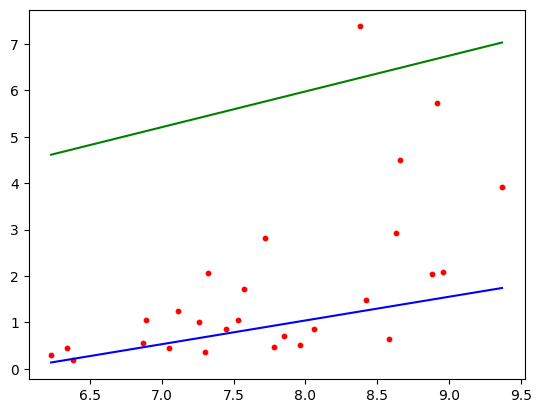

gamma =  0.5114648986474344 ± 0.019409550866228132
b =  -3.0501490406683542 ± 0.14072591076222468
-0.1832074212449957 0.7702788976742732
0.016756290219889173 0.016456416360099632


In [ ]:
#fitting of the galaxies with z>5 and MUV>-19
high_p,err_high_p=linear_fit(high['logMstar'],high['logSFR'],high['e_logSFR'])
norm_p,err_norm_p=linear_fit(high['logMstar_norm'],high['logSFR_dash_norm'],high['e_logSFR'])
plt.scatter(high['logMstar'],high['logSFR'],color='red',s=10)
#plt.errorbar(x,y,co_high,fmt='o',color='r')

b=float(high_p[0])
gamma=float(high_p[1])

beta=float(norm_p[0])
gamma_norm=float(norm_p[1])

k = np.linspace(min(high['logMstar']),max(high['logMstar']),100)
l =(k*gamma)+b

#p=np.linspace(min(high['logMstar_norm']),max(high['logMstar_norm']),100)
q=(k*gamma_norm)+beta

plt.plot(k, l, color='blue')
plt.plot(k,q,color='green')



plt.show()
residual=high['logSFR']-((gamma*high['logMstar'])+b)
delta_sqrd=np.mean((residual**2)-(high['e_logSFR']**2))
print("gamma = ", gamma,'±', np.sqrt(err_high_p[1, 1]))
print("b = ", b ,'±', np.sqrt(err_high_p[0, 0]))
delta=np.sqrt(delta_sqrd)
print(beta,gamma_norm)
print(np.sqrt(err_norm_p[0, 0]),np.sqrt(err_norm_p[1, 1]))


In [ ]:
!pip install emcee
!pip install corner
!pip install multiprocessing


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 2.7 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [ ]:
import emcee
import corner

import multiprocessing

In [ ]:
def Dl_LCDM(z, Omega_m):
    c = 299792.458
    H0 = 70
    Ez_inv = lambda zp: 1.0 / np.sqrt(Omega_m * (1 + zp) ** 3 + (1 - Omega_m))
    integral, _ = integrate.quad(Ez_inv, 0, z)
    return (c / H0) * (1 + z) * integral*3.086*(10**22)


In [ ]:
def Phi(logM_star, DL, beta, gamma):
    DL = np.array(DL)  # Convert to numpy array if not already
    return (beta) + (gamma * logM_star) + (( - 1) * (2 * np.log10(DL) + np.log10(4*np.pi)))

In [ ]:
# Log-likelihood function from Equation (5)
def log_likelihood(theta, logSFR_prime_obs, logM_star_obs, z_obs, DL_obs, logSFR_err, logM_star_err):
    beta, gamma, delta, Omega_m = theta


    if not (0.2 < Omega_m < 0.4):
        return -np.inf



    Dl_vals = np.array([Dl_LCDM(z, Omega_m) for z in z_obs])



    logSFR_model = Phi(logM_star_obs, Dl_vals, beta, gamma)


    s2 = logSFR_err**2 + (gamma**2) * logM_star_err**2 + delta**2


    logL = -0.5 * (np.sum(((logSFR_prime_obs - logSFR_model) ** 2 / s2) + np.log(2 * np.pi * s2)))

    return logL

In [ ]:
# Define log-prior function
def log_prior(theta):
    beta, gamma, delta, Omega_m = theta


    if -3 < beta < 3 and -2 < gamma <  2 and -2 < delta < 2 and 0.2 < Omega_m < 0.5:
        return 0.0
    return -np.inf


In [ ]:
def log_posterior(theta, logSFR_prime_obs, logM_star_obs, z_obs, DL_obs, logSFR_err, logM_star_err):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, logSFR_prime_obs, logM_star_obs, z_obs, DL_obs, logSFR_err, logM_star_err)


2
Running MCMC...


  0%|          | 0/5000 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 5000/5000 [04:14<00:00, 19.67it/s]


Best-fit parameters:
β = -1.620, γ = 0.297, δ = 0.245, Ωm = 0.300


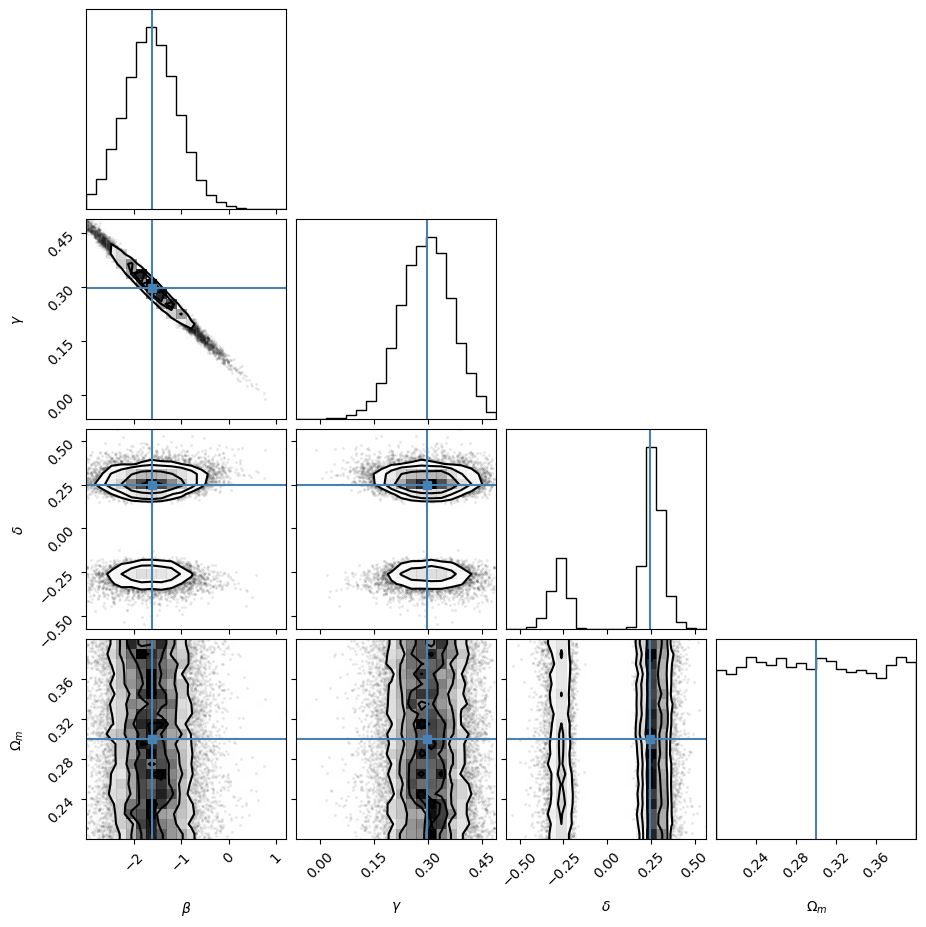

Autocorrelation time: [98.39469065 70.83064217 26.77995453 95.27167906]
Effective Sample Size: 219.7221455255308


In [ ]:

c = 299792.458
H0 = 70


z_obs = high['Z']
DL_obs = np.array([Dl_LCDM(z, 0.3) for z in z_obs])
logSFR_prime_obs = high['logSFR_dash']
logM_star_obs = high['logMstar']
logSFR_err = high['e_logSFR']
logM_star_err =  high['e_Mstar']


ndim = 4
nwalkers = 40
nsteps = 5000



p0 = np.random.normal(loc=[-0.1832074212449957, 0.7702788976742732, 0.281, 0.3], scale=[0.1, 0.05, 0.05, 0.05], size=(nwalkers, ndim))
n_threads = multiprocessing.cpu_count()
print(n_threads)
sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_posterior,
    args=(logSFR_prime_obs, logM_star_obs, z_obs, DL_obs, logSFR_err, logM_star_err)
)

print("Running MCMC...")
sampler.run_mcmc(p0, nsteps, progress=True)
samples = sampler.get_chain(discard=1000, thin=10, flat=True)

best_fit_params = np.median(samples, axis=0)
beta_best, gamma_best, delta_best, Omega_m_best = best_fit_params
low_beta=beta_best
low_gamma=gamma_best
low_delta=delta_best
low_Omega_m=Omega_m_best
print(f"Best-fit parameters:")
print(f"β = {beta_best:.3f}, γ = {gamma_best:.3f}, δ = {delta_best:.3f}, Ωm = {Omega_m_best:.3f}")

# Corner plot of the posterior distribution
fig = corner.corner(samples, labels=[r"$\beta$", r"$\gamma$", r"$\delta$", r"$\Omega_m$"], truths=best_fit_params)
plt.show()
try:
    tau = sampler.get_autocorr_time()
    print(f"Autocorrelation time: {tau}")
    print(f"Effective Sample Size: {len(samples) / np.mean(tau)}")
except:
    print("The chain may not have converged.")


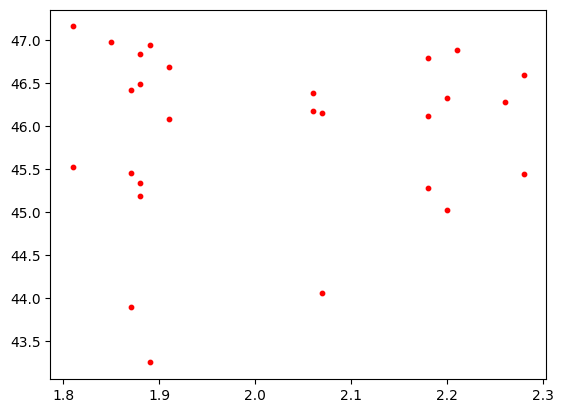

In [ ]:
z_obs = high['Z']
DL_obs = np.array([Dl_LCDM(z, 0.307) for z in z_obs])
f=high['logSFR_dash']-(0.297*(high['logMstar']-np.log10(4*np.pi*DL_obs**2)))+1.622-(0.297-1)*np.log10(4*np.pi)
f=f-((0.297-1)*(44+np.log10(3.086**2)))

dm=(2.5*f/(0.297-1))+25
plt.scatter(z_obs,dm,color='red',s=10)

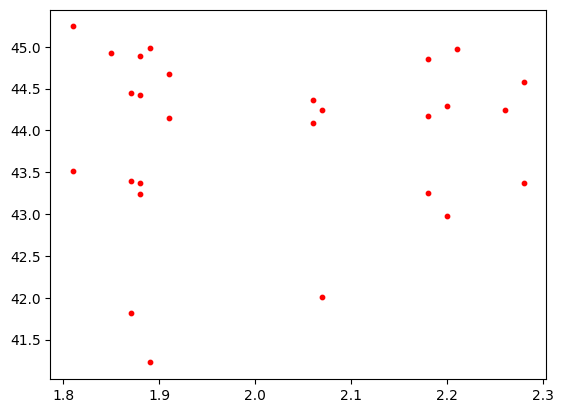

In [ ]:
z_obs = high['Z']
DL_obs = np.array([Dl_LCDM(z, 0.302) for z in z_obs])
f=high['logSFR_dash']-( 0.313*(high['logMstar']-np.log10(4*np.pi*DL_obs**2)))+2.294-( 0.313-1)*np.log10(4*np.pi)
f=f-(( 0.313-1)*(44+np.log10(3.086**2)))

dm=(2.5*f/( 0.313-1))+25
plt.scatter(z_obs,dm,color='red',s=10)